
#### Research Questions:
- RQ1a: Do concept-based interventions reduce cheating behavior?
- RQ1b: Do the effects on cheating vary by concepts?
- RQ2a: Do the interventions affect performance and user experience?
- RQ2b: Do the effects on performance and experience vary by concepts?
- RQ3: How do concept-based interventions influence cheating behavior, performance and user experience?


#### Table of Content

1. **Setup Libraries and Data Preparation**
   - 1.1. Project Setup
   - 1.2. Data Loading and Preparation
   - 1.3. Descriptive Analysis

2. **RQ1: Do Concept-Based Interventions Reduce Cheating Behavior? Do the Effects Vary by Concepts?**
   - 2.1. Cheating Behavior Model Fitting (Bayesian Multinomial Logistic Regression)
     - 2.1.1. Model Diagnostics and Validation
   - 2.2. Cheating Behavior Summary Statistics (Posterior) and Plots

3. **RQ2: Do Concept-Based Interventions Affect Performance and User Experience? Do the Effects Vary by Concepts?**
   - 3.1. Performance and Experience Model Fitting (Multivariate Bayesian Model)
     - 3.1.1. Model Diagnostics and Validation
   - 3.2. Performance and Experience Summary Statistics (Posterior) and Plots

4. **RQ3: How Do Concepts Influence Cheating, Performance, and Experience?**
   - 4.1. Separate Pathway Analysis (Concepts → Psychological Mechanisms; Psychological Mechanisms → Cheating Behavior, Performance, Experience)
   - 4.2. Psychological Networks Analysis


In [ ]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================

# game-behavior-analytics/
# ├── data/
# │   └── final_dataset.csv              # Research dataset
# ├── src/
# │   ├── data/
# │   │   ├── data_loader.py             # Load and validate data
# │   │   └── preprocessor.py            # Create derived variables
# │   ├── models/
# │   │   ├── cheating_model.py          # Bayesian cheating analysis
# │   │   ├── performance_model.py       # Performance/experience analysis
# │   │   └── pathway_model.py          # Pathway analysis between concept, underlying mechanisms, and outcomes
# │   │   └── network_model.py          # Psychological Network analysis
# │   └── visualization/
# │       └── plots.py                   # All plotting functions
# └── notebooks/
#     └── analysis.ipynb                 # Main analysis notebook

### 1. SETUP LIBRARIES AND DATA PREPARATION
PURPOSE: 
- (1.2) Import libraries, load raw dataset and create analysis-ready variables
    - Loads final_dataset.xlsx with participant responses
    - Creates cheating_behavior categories (0=non, 1=partial, 2=full cheater)
    - Creates composite experience variable from satisfaction + engagement
    - Prepares categorical codes for statistical modeling
    - Validates data quality and handles missing values

- (1.3) Explore raw data patterns before statistical modeling
    - Shows cheating distributions: control vs intervention groups
    - Displays performance and experience distributions by cheating behavior
    - Creates Figure 1: Cheating rates comparison (46.6% control vs 36.7% intervention)
    - Provides initial evidence that interventions reduce cheating
    - Sets foundation for formal hypothesis testing in RQ1-RQ3


In [1]:
# ============================================================================
# 1.1. PROJECT SETUP
# ============================================================================

import sys
import os
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

# Change to the correct directory
os.chdir('game-behavior-analytics/data_analysis_notebook/')

In [2]:
# ============================================================================
# 1.2. DATA LOADING AND PREPARATION
# ============================================================================

from src.data.data_loader import load_and_validate_data
from src.data.preprocessor import preprocess_data

print("CHEATING INTERVENTION ANALYSIS")
print("=" * 60)

# Load and preprocess data
df_raw = load_and_validate_data()
df, encoding_info = preprocess_data(df_raw)

print(f"\nDataset ready: {len(df)} participants")
print(f"Intervention concepts: {len(encoding_info['concepts'])}")

CHEATING INTERVENTION ANALYSIS
Dataset loaded: 1282 participants, 62 variables
Cleaned: 50 participants removed, 1232 remaining
Preprocessing complete: 15 intervention concepts
Control group: 73 participants

Dataset ready: 1232 participants
Intervention concepts: 15



OUTCOMES PLOTS: Cheating Behavior, Performance, and Experience


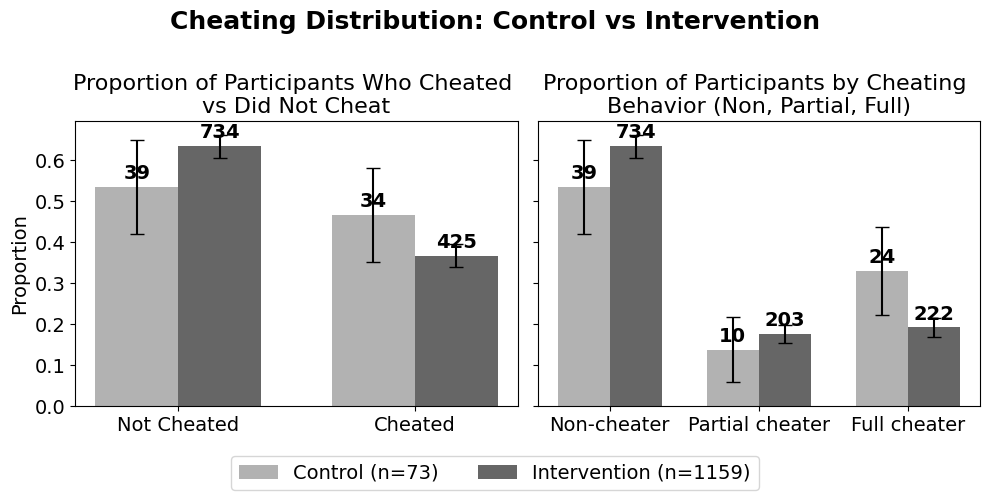

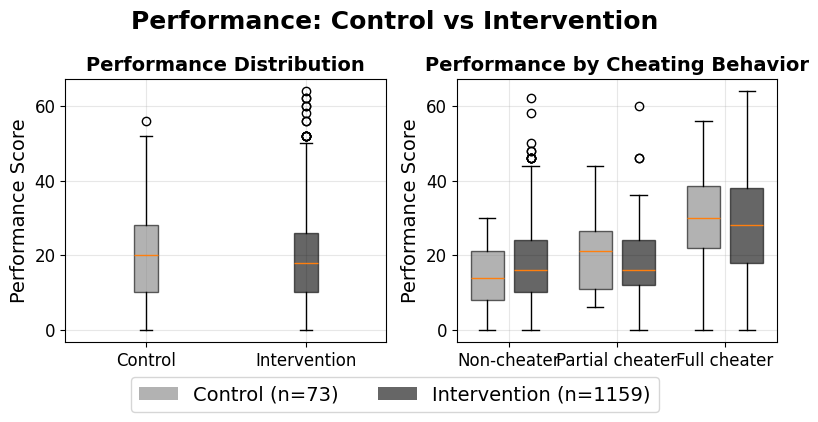

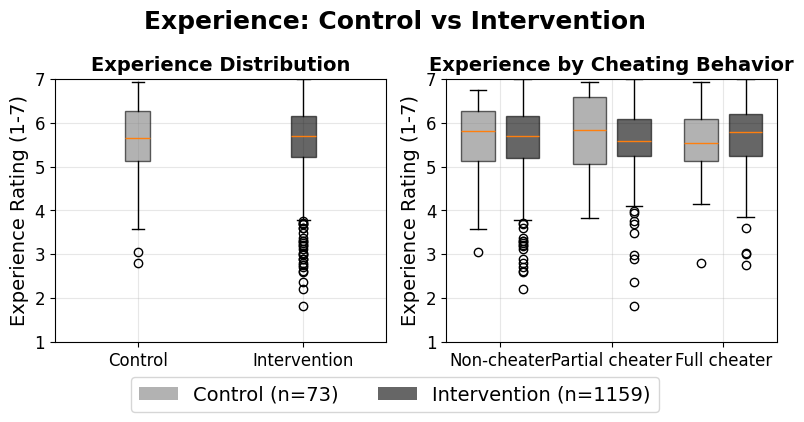


CORRELATION ANALYSIS: PERFORMANCE AND EXPERIENCE
Performance-Experience Correlations (* p<0.05):
       Group Cheating Category   n  Correlation p-value Sig
     Control      Non-cheaters  39        0.339   0.035   *
     Control  Partial cheaters  10       -0.427   0.219  ns
     Control     Full cheaters  24        0.203   0.341  ns
Intervention      Non-cheaters 734        0.115   0.002   *
Intervention  Partial cheaters 203        0.006   0.928  ns
Intervention     Full cheaters 222        0.222   0.001   *

Decision: 5/6 groups have |r|>0.1, 3 significant
Using multivariate model(s) for performance and experience


In [3]:
# ============================================================================
# 1.3. DESCRIPTIVE ANALYSIS WITH CORRELATION SIGNIFICANCE TESTING
# ============================================================================

from src.visualization.plots import plot_descriptive_stats
import pandas as pd
import numpy as np
from scipy import stats

print("\n" + "=" * 60)
print("OUTCOMES PLOTS: Cheating Behavior, Performance, and Experience")
print("=" * 60)

plot_descriptive_stats(df)

print("\n" + "=" * 80)
print("CORRELATION ANALYSIS: PERFORMANCE AND EXPERIENCE")
print("=" * 80)

# Calculate correlations with significance testing
corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_data in [('Control', df[df['concept'] == 'control']), 
                               ('Intervention', df[df['concept'] != 'control'])]:
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]
        
        if len(subset) >= 10:
            corr, p_value = stats.pearsonr(subset['performance'], subset['experience'])
            sig_str = "*" if p_value < 0.05 else "ns"
        else:
            corr, p_value, sig_str = None, None, 'NA'
        
        corr_results.append({
            'Group': group_name,
            'Cheating Category': cheating_labels[cheat_cat],
            'n': len(subset),
            'Correlation': round(corr, 3) if corr is not None else 'NA',
            'p-value': f"{p_value:.3f}" if p_value is not None else 'NA',
            'Sig': sig_str
        })

# Display table
corr_table = pd.DataFrame(corr_results)
print("Performance-Experience Correlations (* p<0.05):")
print(corr_table.to_string(index=False))

# Decision criterion for multivariate modeling
significant_corrs = sum(1 for r in corr_results if r['Sig'] == '*')
substantial_corrs = sum(1 for r in corr_results 
                       if r['Correlation'] != 'NA' and abs(r['Correlation']) > 0.1 and r['n'] >= 10)

print(f"\nDecision: {substantial_corrs}/6 groups have |r|>0.1, {significant_corrs} significant")
print(f"Using {'multivariate' if substantial_corrs >= 3 else 'separate'} model(s) for performance and experience")

### 2. RQ1: CHEATING BEHAVIOR ANALYSIS

Answers these two research questions ~
- #### RQ1a: Do concept-based interventions reduce cheating behavior?
- #### RQ1b: Do the effects on cheating vary by concepts?


We do this by:
- (2.1) Fits Bayesian multinomial logistic regression (3 cheating categories)
    - Controls for motivational message variations through random effects
    - Uses empirical priors from control group baseline rates
    - Tests 15 intervention concepts across 4 psychological theories
    - Provides diagnostic checks for model fit and convergence in 2.1.1
- (2.2) Analyzes model results to answer RQ1a and RQ1b
    - Produces Figure: Overall intervention effects
    - Produces Figure: Concept-specific effects



In [11]:
# Raw percentage changes by concept vs control
control = df[df['concept'] == 'control']
control_props = control['cheating_behavior'].value_counts(normalize=True).sort_index() * 100

print("RAW PERCENTAGE CHANGES BY CONCEPT (vs Control)")
print("=" * 80)
print(f"{'Concept':<25} {'Non-cheater':<15} {'Partial':<15} {'Full':<15} {'n':<5}")
print("-" * 80)

# Control baseline
ctrl_non = control_props.iloc[0] if 0 in control_props.index else 0
ctrl_partial = control_props.iloc[1] if 1 in control_props.index else 0  
ctrl_full = control_props.iloc[2] if 2 in control_props.index else 0

print(f"{'Control (baseline)':<30} {ctrl_non:>6.1f}%        {ctrl_partial:>6.1f}%        {ctrl_full:>6.1f}%        {len(control):<5}")
print("-" * 80)

# Each concept vs control
for concept in df[df['concept'] != 'control']['concept'].unique():
    subset = df[df['concept'] == concept]
    props = subset['cheating_behavior'].value_counts(normalize=True).sort_index() * 100
    
    non_pct = props.iloc[0] if 0 in props.index else 0
    partial_pct = props.iloc[1] if 1 in props.index else 0
    full_pct = props.iloc[2] if 2 in props.index else 0
    
    # Calculate differences
    non_diff = non_pct - ctrl_non
    partial_diff = partial_pct - ctrl_partial
    full_diff = full_pct - ctrl_full
    
    concept_clean = concept.replace('_', ' ').title()
    print(f"{concept_clean:<30} {non_diff:>+6.1f}%       {partial_diff:>+6.1f}%       {full_diff:>+6.1f}%       {len(subset):<5}")


RAW PERCENTAGE CHANGES BY CONCEPT (vs Control)
Concept                   Non-cheater     Partial         Full            n    
--------------------------------------------------------------------------------
Control (baseline)               53.4%          13.7%          32.9%        73   
--------------------------------------------------------------------------------
Performance Accomplishments      +3.7%         +7.1%        -10.8%       77   
Emotional Arousal                +3.7%         +4.5%         -8.2%       77   
Dissonance Arousal              +10.2%         -2.0%         -8.2%       77   
Reference Group Identification  +18.0%         -2.0%        -16.0%       77   
Relatedness                     +10.7%         -0.9%         -9.8%       78   
Social Sanctions                 +6.8%         +9.4%        -16.2%       78   
Competence                      +12.8%         -0.7%        -12.1%       77   
Cognitive Inconsistency         +13.7%         +6.0%        -19.7%       76 

In [4]:
# ==========================================================================================
# 2.1. CHEATING BEHAVIOR MODEL FITTING (BAYESIAN MULTINOMIAL LOGISTIC REGRESSION)
# ==========================================================================================

"""
REGRESSION EQUATION FOR CHEATING BEHAVIOR MODEL:

Multinomial Logistic Regression (3 categories: Non-cheater=0, Partial cheater=1, Full cheater=2)

log(P(Partial)/P(Non)) = β₀_partial + Σ(αᵢ x Conceptᵢ) + γⱼ x Messageⱼ
log(P(Full)/P(Non))    = β₀_full + Σ(δᵢ x Conceptᵢ) + ηⱼ x Messageⱼ

Where:
- Dependent Variable: cheating_behavior (0=Non-cheater, 1=Partial cheater, 2=Full cheater)
- Independent Variables:
  * Conceptᵢ: Dummy variables for 15 intervention concepts (reference = control)
  * Messageⱼ: Random effects for motivational message variations
- Parameters:
  * β₀_partial, β₀_full: Control group baselines (empirical priors)
  * αᵢ, δᵢ: Concept effects on partial/full cheating
  * γⱼ, ηⱼ: Random message effects

Model uses empirical Bayesian priors from control group and handles missing concepts
through indicator variables.
"""

from src.models.cheating_model import analyze_cheating_behavior

cheating_trace, cheating_effects = analyze_cheating_behavior(df, encoding_info)

Fitting cheating behavior model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mu_concept_partial, sigma_concept_partial, concept_effects_partial, mu_concept_full, sigma_concept_full, concept_effects_full]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 44 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✓ Cheating model completed



MODEL DIAGNOSTICS


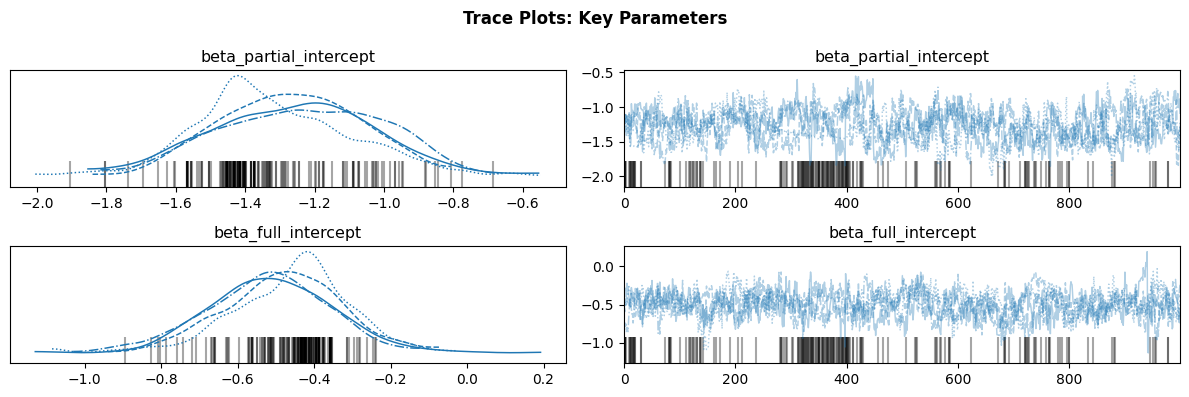

Sampling: [cheating_obs]


Output()

<Axes: xlabel='cheating_obs'>

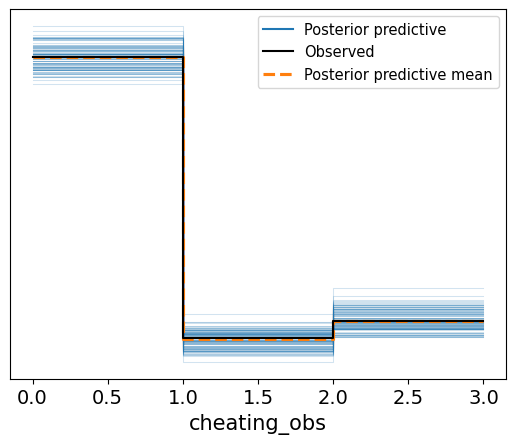

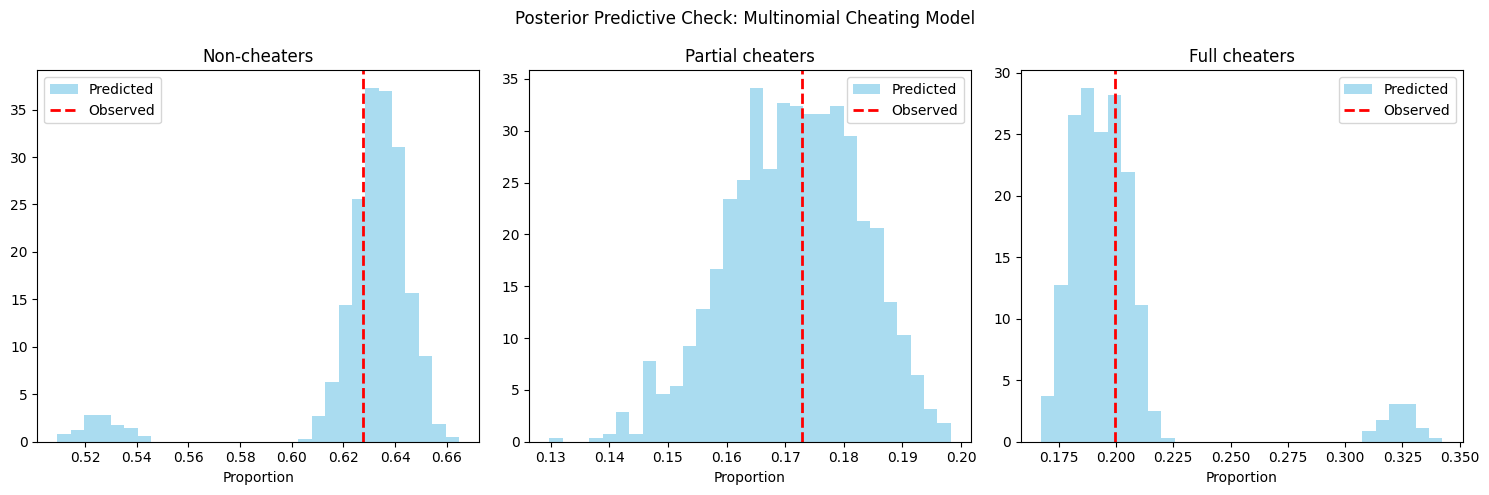

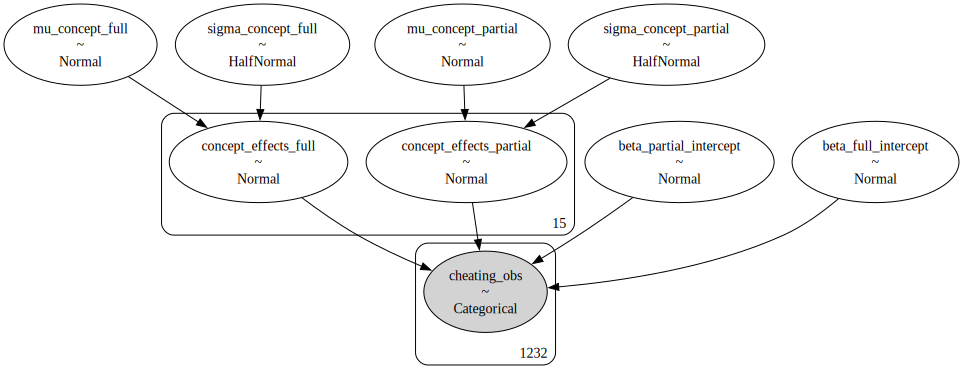

✓ Model diagnostics completed


In [5]:
# ==========================================================================================
# 2.1.1. MODEL DIAGNOSTICS AND VALIDATION
# ==========================================================================================

import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("MODEL DIAGNOSTICS")
print("="*60)

# Trace plots
az.plot_trace(cheating_trace, var_names=['beta_partial_intercept', 'beta_full_intercept'], compact=True)
plt.suptitle('Trace Plots: Key Parameters', fontweight='bold')
plt.tight_layout()
plt.show()

# Posterior predictive check
with cheating_effects['model']:
    ppc_cheating = pm.sample_posterior_predictive(cheating_trace, random_seed=42)
    display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

# Custom PPC plots by category
y_cheating_behavior = df['cheating_behavior'].values
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_cheating_behavior == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['cheating_obs'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, label='Predicted', color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Multinomial Cheating Model')
plt.tight_layout()
plt.show()

# Model graph
if 'model' in cheating_effects:
    try:
        with cheating_effects['model']:
            graph = pm.model_to_graphviz()
            display(graph)
    except:
        print("Model graph requires graphviz installation")
else:
    print("Model not available for graph visualization")

print("✓ Model diagnostics completed")


RQ1: CHEATING BEHAVIOR RESULTS TABLE
Concept                             Theory                         Non-cheater               Partial cheater           Full cheater             
---------------------------------------------------------------------------------------------------------------------------------------
OVERALL INTERVENTION EFFECT         All Theories Combined          +10.9 [+4.1, +17.5]       +2.2 [-3.8, +7.9]         -13.1 [-20.2, -6.4]      
---------------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +11.1 [+2.5, +18.5]       +2.7 [-4.6, +9.6]         -13.9 [-21.8, -5.7]      
Competence                          Self-Determination Theory      +11.1 [+3.3, +18.9]       +1.4 [-5.7, +8.1]         -12.6 [-20.1, -3.7]      
Relatedness                         Self-Determination Theory      +10.9 [+2.8, +18.8]       +1.3 [-6.3, +7.8]

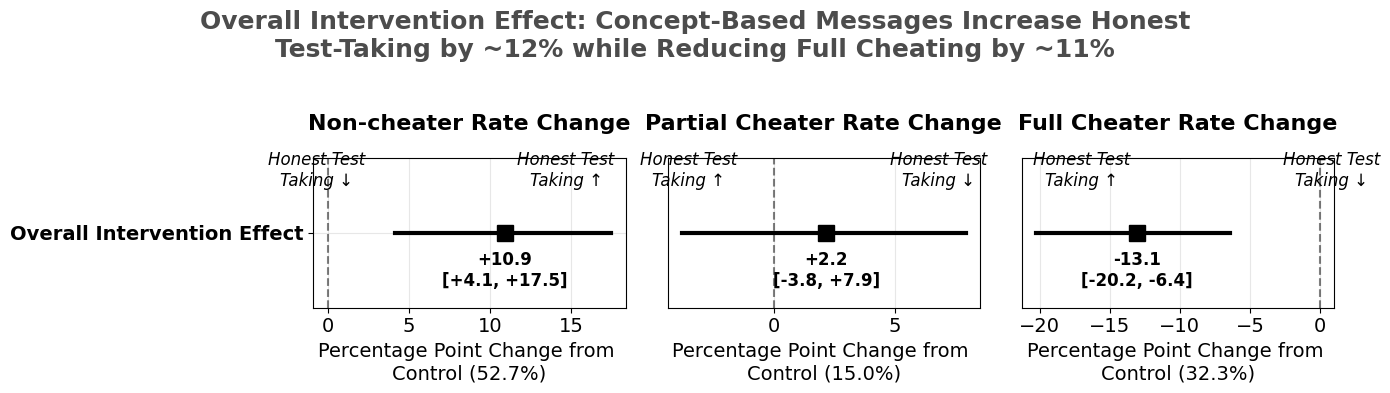

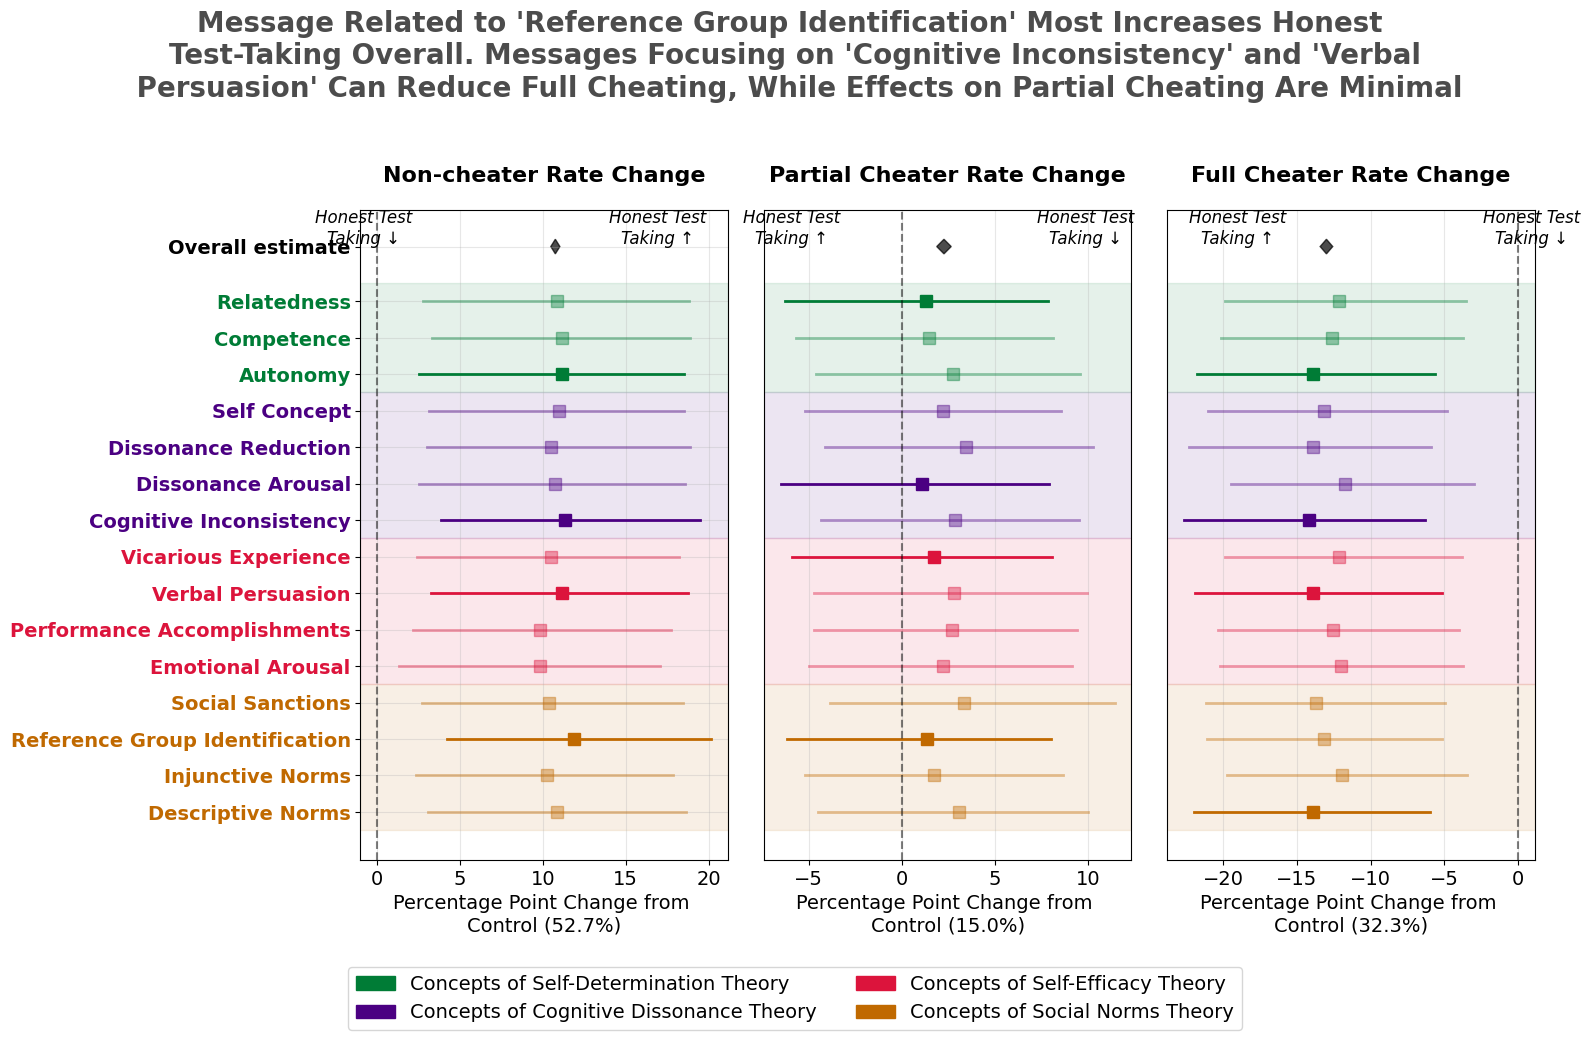

In [6]:
# ==========================================================================================
# 2.2. CHEATING BEHAVIOR SUMMARY STATISTICS (POSTERIOR) AND PLOTS
# ==========================================================================================

from src.visualization.plots import plot_cheating_effects

# Print RQ1 posterior effects table
print("\n" + "="*120)
print("RQ1: CHEATING BEHAVIOR RESULTS TABLE")
print("="*120)

# Header
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial cheater':<25} {'Full cheater':<25}")
print("-" * 135)

# Overall intervention effect (first row)
overall = cheating_effects['overall_effects']
non_str = f"{overall['Non']['mean']:+.1f} [{overall['Non']['hdi'][0]:+.1f}, {overall['Non']['hdi'][1]:+.1f}]"
partial_str = f"{overall['Partial']['mean']:+.1f} [{overall['Partial']['hdi'][0]:+.1f}, {overall['Partial']['hdi'][1]:+.1f}]"
full_str = f"{overall['Full']['mean']:+.1f} [{overall['Full']['hdi'][0]:+.1f}, {overall['Full']['hdi'][1]:+.1f}]"

print(f"{'OVERALL INTERVENTION EFFECT':<35} {'All Theories Combined':<30} {non_str:<25} {partial_str:<25} {full_str:<25}")
print("-" * 135)

# Individual concepts
concept_results = cheating_effects['concept_effects']
for result in concept_results:
    concept_name = result['concept_label']
    theory = result['theory']
    
    non_str = f"{result['non_mean']:+.1f} [{result['non_hdi'][0]:+.1f}, {result['non_hdi'][1]:+.1f}]"
    partial_str = f"{result['partial_mean']:+.1f} [{result['partial_hdi'][0]:+.1f}, {result['partial_hdi'][1]:+.1f}]"
    full_str = f"{result['full_mean']:+.1f} [{result['full_hdi'][0]:+.1f}, {result['full_hdi'][1]:+.1f}]"
    
    print(f"{concept_name:<35} {theory:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


plot_cheating_effects(cheating_effects)

### 3. RQ2: PERFORMANCE AND EXPERIENCE ANALYSIS

Answers these two research questions ~
- #### RQ2a: Do the interventions affect performance and user experience?
- #### RQ2b: Do the effects on performance and experience vary by concepts?


We do this by:
- (3.1) Fits multivariate Bayesian model for correlated performance-experience outcomes
    - Moderate Correlations (ρ = 0.4 for control non-cheater) between these two outcomes determined multivariate modeling approach
    - Models concept × cheating category interactions (differential effects)
    - Controls for message variations and accounts for outcome correlation 
    - Provides diagnostic checks for model fit and convergence in 3.1.1
- (3.2) Analyzes model results to answer RQ1a and RQ1b
    - Produces Figure: Overall intervention effects
- Key finding: All effects near zero with 95% HDI spanning zero
- Conclusion: Interventions achieve integrity goals without performance/experience costs

In [ ]:
# ==========================================================================================
# 3.1. PERFORMANCE AND EXPERIENCE MODEL FITTING (MULTIVARIATE BAYESIAN MODEL)
# ==========================================================================================

"""
REGRESSION EQUATION FOR PERFORMANCE AND EXPERIENCE MODEL:

Multivariate Hierarchical Regression with Correlated Outcomes:

Performance_i = μ_perf_ctrl[cheating_i] + β_perf_main[concept_i] + β_perf_int[concept_i, cheating_i] + γ_perf[message_i] + ε_perf_i
Experience_i = μ_exp_ctrl[cheating_i] + β_exp_main[concept_i] + β_exp_int[concept_i, cheating_i] + γ_exp[message_i] + ε_exp_i

Where (ε_perf_i, ε_exp_i) ~ MVN(0, Σ) with covariance matrix Σ = [[σ²_perf, ρσ_perf σ_exp], [ρσ_perf σ_exp, σ²_exp]]

Variables:
- Dependent Variables: 
  * Performance: performance_score_including_cheated_words (continuous)
  * Experience: (task_satisfaction + task_engagement)/2 (continuous, 1-7 scale)
- Independent Variables:
  * concept_i: Intervention concept indicator (reference = control)
  * cheating_i: Cheating behavior category (0=non, 1=partial, 2=full)
  * message_i: Random effect for motivational message variations
- Parameters:
  * μ_perf_ctrl, μ_exp_ctrl: Control group baselines by cheating category
  * β_perf_main, β_exp_main: Main concept effects
  * β_perf_int, β_exp_int: Concept x cheating category interactions
  * ρ: Performance-experience correlation coefficient
  * σ_perf, σ_exp: Outcome-specific standard deviations

Model accounts for heterogeneous correlation patterns across cheating groups.
"""

from src.models.performance_model import analyze_performance_experience

perf_exp_effects = analyze_performance_experience(df, encoding_info)
perf_exp_trace = perf_exp_effects.get('trace', None)

In [ ]:
# ==========================================================================================
# 3.1.1. MODEL DIAGNOSTICS AND VALIDATION
# ==========================================================================================

import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("MODEL DIAGNOSTICS")
print("="*60)

# Trace plots for key parameters
az.plot_trace(perf_exp_trace, var_names=['sigma_perf', 'sigma_exp', 'rho'], compact=True)
plt.suptitle('Trace Plots: Key Parameters', fontweight='bold')
plt.tight_layout()
plt.show()

# Posterior predictive check
with perf_exp_effects['model']:
    ppc_perf_exp = pm.sample_posterior_predictive(perf_exp_trace, random_seed=42)
    
    # Performance PPC
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Performance
    az.plot_ppc(ppc_perf_exp, data_pairs={"outcomes": "outcomes"}, 
            num_pp_samples=100, ax=axes[0], coords={"outcomes_dim_0": 1})
    axes[0].set_title('Performance Posterior Predictive Check')
    
    # Experience  
    az.plot_ppc(ppc_perf_exp, data_pairs={"outcomes": "outcomes"}, 
                num_pp_samples=100, ax=axes[1], coords={"outcomes_dim_0": 0})
    axes[1].set_title('Experience Posterior Predictive Check')
    
    plt.tight_layout()
    plt.show()

# Model graph
if 'model' in perf_exp_effects:
    try:
        with perf_exp_effects['model']:
            graph = pm.model_to_graphviz()
            display(graph)
    except:
        print("Model graph requires graphviz installation")

print("✓ Model diagnostics completed")


In [ ]:
# ==========================================================================================
# 3.2. PERFORMANCE AND EXPERIENCE SUMMARY STATISTICS (POSTERIOR) AND PLOTS
# ==========================================================================================
from src.visualization.plots import plot_performance_experience_effects

# Print RQ2 posterior effects table
print("\n" + "="*150)
print("RQ2: PERFORMANCE AND EXPERIENCE RESULTS TABLE")
print("="*150)

# Performance Table
print("\nPERFORMANCE EFFECTS (Raw Score Changes)")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial cheater':<25} {'Full cheater':<25}")
print("-" * 140)

# Overall intervention effect (first row)
if 'multivariate_results' in perf_exp_effects:
    overall = perf_exp_effects['multivariate_results']
    perf_non_str = f"{overall['perf_non']['mean']:+.2f} [{overall['perf_non']['hdi'][0]:+.2f}, {overall['perf_non']['hdi'][1]:+.2f}]"
    perf_partial_str = f"{overall['perf_partial']['mean']:+.2f} [{overall['perf_partial']['hdi'][0]:+.2f}, {overall['perf_partial']['hdi'][1]:+.2f}]"
    perf_full_str = f"{overall['perf_full']['mean']:+.2f} [{overall['perf_full']['hdi'][0]:+.2f}, {overall['perf_full']['hdi'][1]:+.2f}]"
    
    print(f"{'OVERALL INTERVENTION EFFECT':<35} {'All Theories Combined':<30} {perf_non_str:<25} {perf_partial_str:<25} {perf_full_str:<25}")
    print("-" * 140)
    
    # Individual concepts
    if 'concept_effects' in perf_exp_effects:
        concept_results = perf_exp_effects['concept_effects']
        for result in concept_results:
            concept_name = result['concept_label']
            theory = result['theory']
            
            perf_non_str = f"{result['perf_non_mean']:+.2f} [{result['perf_non_hdi'][0]:+.2f}, {result['perf_non_hdi'][1]:+.2f}]"
            perf_partial_str = f"{result['perf_partial_mean']:+.2f} [{result['perf_partial_hdi'][0]:+.2f}, {result['perf_partial_hdi'][1]:+.2f}]"
            perf_full_str = f"{result['perf_full_mean']:+.2f} [{result['perf_full_hdi'][0]:+.2f}, {result['perf_full_hdi'][1]:+.2f}]"
            
            print(f"{concept_name:<35} {theory:<30} {perf_non_str:<25} {perf_partial_str:<25} {perf_full_str:<25}")

# Experience Table
print("\n" + "="*150)
print("EXPERIENCE EFFECTS (7-point Scale Changes)")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial cheater':<25} {'Full cheater':<25}")
print("-" * 140)

# Overall intervention effect (first row)
if 'multivariate_results' in perf_exp_effects:
    exp_non_str = f"{overall['exp_non']['mean']:+.3f} [{overall['exp_non']['hdi'][0]:+.3f}, {overall['exp_non']['hdi'][1]:+.3f}]"
    exp_partial_str = f"{overall['exp_partial']['mean']:+.3f} [{overall['exp_partial']['hdi'][0]:+.3f}, {overall['exp_partial']['hdi'][1]:+.3f}]"
    exp_full_str = f"{overall['exp_full']['mean']:+.3f} [{overall['exp_full']['hdi'][0]:+.3f}, {overall['exp_full']['hdi'][1]:+.3f}]"
    
    print(f"{'OVERALL INTERVENTION EFFECT':<35} {'All Theories Combined':<30} {exp_non_str:<25} {exp_partial_str:<25} {exp_full_str:<25}")
    print("-" * 140)
    
    # Individual concepts
    if 'concept_effects' in perf_exp_effects:
        for result in concept_results:
            concept_name = result['concept_label']
            theory = result['theory']
            
            exp_non_str = f"{result['exp_non_mean']:+.3f} [{result['exp_non_hdi'][0]:+.3f}, {result['exp_non_hdi'][1]:+.3f}]"
            exp_partial_str = f"{result['exp_partial_mean']:+.3f} [{result['exp_partial_hdi'][0]:+.3f}, {result['exp_partial_hdi'][1]:+.3f}]"
            exp_full_str = f"{result['exp_full_mean']:+.3f} [{result['exp_full_hdi'][0]:+.3f}, {result['exp_full_hdi'][1]:+.3f}]"
            
            print(f"{concept_name:<35} {theory:<30} {exp_non_str:<25} {exp_partial_str:<25} {exp_full_str:<25}")

# Plot effects
plot_performance_experience_effects(perf_exp_effects)

### 4. RQ3: How do concept-based interventions influence cheating behavior, performance and user experience?

We aim to understand if concept-based interventions work through desired psychological pathways?

- (4.1) PATHWAY ANALYSIS:
    - Tests coefficients in two pathways: {Concepts → Psychological Mechanisms} and {Psychological Mechanisms → Outcomes}
    - Analyzes 5 psychological mechanisms (Need Satisfaction, Need Frustration, Self-Efficacy, Norm Perception, Cognitive Discomfort)
    - Separate models for each pathway to isolate effects
    - Key finding: Limited mediation - mechanisms weakly activated and inconsistently predict outcomes

- (4.2) NETWORK ANALYSIS:
    - Maps correlational structures between mechanisms and outcomes
    - Compares psychological networks: control vs intervention vs individual concepts
    - Uses partial correlations to identify direct relationships
    - Reveals concept-specific mechanism activation patterns
    - Shows how different theories create different psychological network structures

In [ ]:
# ========================================================================================================
# 4.1. SEPARATE PATHWAY ANALYSIS 
# (CONCEPTS → PSYCHOLOGICAL MECHANISMS) (PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR, PERFORMANCE, EXPERIENCE)
# ========================================================================================================

"""
REGRESSION EQUATIONS FOR PATHWAY ANALYSIS:

MODEL 1 - CONCEPTS → PSYCHOLOGICAL MECHANISMS (PATHWAY 1):
Mechanism_i = β₀[cheating_i] + αⱼ[concept_j, cheating_i] + γₖ[message_k] + ε_i

MODEL 2 - PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR (PATHWAY 2a):
log(P(Partial)/P(Non)) = β₀_partial + Σ(δₘ x Mechanism_m)
log(P(Full)/P(Non))    = β₀_full + Σ(ζₘ x Mechanism_m)

MODEL 3 - PSYCHOLOGICAL MECHANISMS → PERFORMANCE/EXPERIENCE (PATHWAY 2b):
Performance_i = β₀_perf[cheating_i] + Σ(θₘ[cheating_i] x Mechanism_m) + ε_perf_i
Experience_i = β₀_exp[cheating_i] + Σ(ψₘ[cheating_i] x Mechanism_m) + ε_exp_i

Where:
- Mechanisms: Need Satisfaction, Need Frustration, Self-Efficacy, Norm Perception, Cognitive Discomfort
- All mechanisms are standardized (z-scores)
- PATHWAY 1 tests concept → mechanism activation
- PATHWAY 2,3 test mechanism → outcome relationships
- Models are stratified by cheating behavior groups for differential effects

This approach separates mediation pathways to identify which psychological mechanisms
are activated by interventions and which mechanisms influence outcomes.
"""

from src.models.pathway_model import analyze_psychological_pathways
from src.visualization.plots import plot_pathway_effects, print_pathway_summary

print("Analysis Strategy:")
print("1. Overall Intervention → Psychological Mechanisms")
print("2. Psychological Mechanisms → Cheating Behavior")  
print("3. Psychological Mechanisms → Performance/Experience")

# Analyze pathways
pathway_results = analyze_psychological_pathways(df, encoding_info)

if pathway_results:
    # Create all pathway plots
    plot_pathway_effects(pathway_results)
    
    # Print detailed results tables
    print_pathway_summary(pathway_results)
else:
    print("Pathway analysis not possible with available data")
    print("RQ3.2: Cannot determine psychological pathways with current variables")

In [ ]:
# ============================================================================
# 4.2. PSYCHOLOGICAL NETWORKS ANALYSIS - UPDATED WITH ALL CONCEPTS AS NODES
# ============================================================================

from src.models.network_model import prepare_network_data, estimate_partial_correlations
from src.visualization.plots import print_partial_correlation_tables
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def prepare_expanded_network_data(df):
    """Prepare network data with concepts, mechanisms, outcomes, and moderators as nodes"""
    
    # Core mechanisms and outcomes (existing)
    core_vars = {
        'need_satisfaction': 'overall_need_satisfaction',
        'need_frustration': 'overall_need_frustration', 
        'self_efficacy': 'task_specific_self_efficacy',
        'norm_perception': 'norm_perception',
        'cognitive_discomfort': 'cognitive_discomfort',
        'cheating': 'cheating_behavior',
        'performance': 'performance', 
        'experience': 'experience'
    }
    
    # Add all 15 concepts as binary nodes (0/1 indicators)
    concept_vars = {}
    concepts = encoding_info['concepts']  # All 15 intervention concepts
    
    for concept in concepts:
        concept_vars[f'concept_{concept}'] = concept
    
    # Add moderators
    moderator_vars = {
        'perceived_ability': 'word_creation_skill_level',
        'moral_disengagement': 'moral_disengagement'
    }
    
    # Combine all variables
    all_vars = {**core_vars, **moderator_vars}
    
    # Check availability and extract data
    available_data = {}
    
    # Core variables and moderators (continuous)
    for node_name, col_name in all_vars.items():
        if col_name in df.columns and df[col_name].notna().sum() > 100:
            available_data[node_name] = df[col_name].values
    
    # Concept indicators (binary)
    for concept in concepts:
        node_name = f'concept_{concept}'
        # Create binary indicator: 1 if participant received this concept, 0 otherwise
        indicator = (df['concept'] == concept).astype(int).values
        available_data[node_name] = indicator
    
    # Convert to DataFrame and standardize
    network_data = pd.DataFrame(available_data)
    
    # Standardize all variables for network analysis
    scaler = StandardScaler()
    network_data_scaled = pd.DataFrame(
        scaler.fit_transform(network_data),
        columns=network_data.columns,
        index=network_data.index
    )
    
    return network_data_scaled

def analyze_expanded_networks_by_group(df):
    """Analyze networks with expanded node set by participant groups"""
    
    network_data = prepare_expanded_network_data(df)
    labels = list(network_data.columns)
    
    # Analyze networks by major groups
    groups_to_analyze = [
        ('control', df['concept'] == 'control'),
        ('overall_intervention', df['concept'] != 'control'),
        # Add theory-based groups
        ('self_determination', df['concept'].isin(['autonomy', 'competence', 'relatedness'])),
        ('cognitive_dissonance', df['concept'].isin(['self_concept', 'cognitive_inconsistency', 
                                                    'dissonance_arousal', 'dissonance_reduction'])),
        ('self_efficacy', df['concept'].isin(['performance_accomplishments', 'vicarious_experience', 
                                             'verbal_persuasion', 'emotional_arousal'])),
        ('social_norms', df['concept'].isin(['descriptive_norms', 'injunctive_norms', 
                                            'social_sanctions', 'reference_group_identification']))
    ]
    
    results = {}
    
    for group_name, group_mask in groups_to_analyze:
        group_data = network_data[group_mask]
        if len(group_data) >= 10:  # Minimum sample size
            partial_corr = estimate_partial_correlations(group_data)
            results[group_name] = {
                'partial_correlations': partial_corr,
                'n_participants': len(group_data)
            }
    
    return results, labels

def plot_expanded_network_comparison(network_results, labels):
    """Plot network comparison with expanded node set"""
    
    import matplotlib.pyplot as plt
    import networkx as nx
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Define node types and colors
    node_types = {
        'mechanisms': [l for l in labels if l in ['need_satisfaction', 'need_frustration', 
                                                 'self_efficacy', 'norm_perception', 'cognitive_discomfort']],
        'outcomes': [l for l in labels if l in ['cheating', 'performance', 'experience']],
        'concepts': [l for l in labels if l.startswith('concept_')],
        'moderators': [l for l in labels if l in ['perceived_ability', 'moral_disengagement']]
    }
    
    node_colors = {
        'mechanisms': 'lightblue',
        'outcomes': 'salmon', 
        'concepts': 'lightgreen',
        'moderators': 'gold'
    }
    
    threshold = 0.15
    
    groups_to_plot = ['control', 'overall_intervention', 'self_determination', 
                     'cognitive_dissonance', 'self_efficacy', 'social_norms']
    
    for i, group in enumerate(groups_to_plot):
        ax = axes[i]
        
        if group in network_results:
            matrix = network_results[group]['partial_correlations']
            n = network_results[group]['n_participants']
            
            # Create network graph
            G = nx.Graph()
            
            # Add nodes with positions based on type
            pos = {}
            y_positions = {'mechanisms': 0.8, 'outcomes': 0.2, 'concepts': 0.5, 'moderators': 0.35}
            
            node_idx = 0
            for node_type, nodes in node_types.items():
                n_nodes = len([n for n in nodes if n in labels])
                if n_nodes > 0:
                    x_positions = np.linspace(0.1, 0.9, n_nodes)
                    type_idx = 0
                    for node in nodes:
                        if node in labels:
                            label_idx = labels.index(node)
                            G.add_node(label_idx, label=node, type=node_type)
                            pos[label_idx] = (x_positions[type_idx], y_positions[node_type])
                            type_idx += 1
            
            # Add significant edges
            for j in range(len(labels)):
                for k in range(j+1, len(labels)):
                    if j in G.nodes() and k in G.nodes():
                        weight = matrix[j, k]
                        if abs(weight) > threshold:
                            G.add_edge(j, k, weight=weight)
            
            # Draw network
            if G.nodes():
                # Edges
                if G.edges():
                    edge_weights = [abs(G[u][v]['weight']) * 3 for u, v in G.edges()]
                    edge_colors = ['red' if G[u][v]['weight'] < 0 else 'green' for u, v in G.edges()]
                    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, 
                                         edge_color=edge_colors, alpha=0.6)
                
                # Nodes by type
                for node_type, color in node_colors.items():
                    nodes_of_type = [n for n in G.nodes() if G.nodes[n].get('type') == node_type]
                    if nodes_of_type:
                        nx.draw_networkx_nodes(G, pos, nodelist=nodes_of_type, 
                                             node_color=color, node_size=300, alpha=0.8, ax=ax)
                
                # Labels (abbreviated for space)
                label_dict = {}
                for node in G.nodes():
                    label = G.nodes[node]['label']
                    if label.startswith('concept_'):
                        # Abbreviate concept names
                        concept_name = label.replace('concept_', '').replace('_', '.')[:8]
                        label_dict[node] = concept_name
                    elif len(label) > 8:
                        label_dict[node] = label[:8]
                    else:
                        label_dict[node] = label
                
                nx.draw_networkx_labels(G, pos, labels=label_dict, ax=ax, 
                                      font_size=8, font_weight='bold')
        
        ax.set_title(f'{group.replace("_", " ").title()}\n(n={network_results.get(group, {}).get("n_participants", 0)})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                                 markersize=10, label=node_type.title()) 
                      for node_type, color in node_colors.items()]
    legend_elements.extend([
        plt.Line2D([0], [0], color='green', linewidth=3, label='Positive Correlation (r > +0.15)'),
        plt.Line2D([0], [0], color='red', linewidth=3, label='Negative Correlation (r < -0.15)')
    ])
    
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.02), 
               ncol=3, fontsize=11)
    
    plt.suptitle('Extended Psychological Networks: Concepts, Mechanisms, Outcomes & Moderators', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.85)
    plt.show()

# Execute expanded network analysis
print("Analyzing extended networks with all concepts as nodes...")

# Run expanded analysis
expanded_network_results, expanded_labels = analyze_expanded_networks_by_group(df)

print(f"Extended networks estimated for {len(expanded_network_results)} groups")
print(f"Total network variables: {len(expanded_labels)}")
print(f"Variables include: {len([l for l in expanded_labels if l.startswith('concept_')])} concepts, "
      f"{len([l for l in expanded_labels if not l.startswith('concept_')])} other variables")

# Plot expanded networks
plot_expanded_network_comparison(expanded_network_results, expanded_labels)

In [ ]:
# ============================================================================
# PSYCHOLOGICAL MECHANISMS BY CHEATING GROUPS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("Psychological Mechanisms by Cheating Groups")
print("-" * 60)

# Define mechanisms
mechanisms = {
    'overall_need_satisfaction': 'Need Satisfaction',
    'overall_need_frustration': 'Need Frustration', 
    'task_specific_self_efficacy': 'Self Efficacy',
    'norm_perception': 'Norm Perception',
    'cognitive_discomfort': 'Cognitive Discomfort'
}

# Check available mechanisms
available_mechs = {}
for var, label in mechanisms.items():
    if var in df.columns and df[var].notna().sum() > 100:
        available_mechs[label] = var
        print(f"✓ {label}: {df[var].notna().sum()} values")

if len(available_mechs) == 0:
    print("No psychological mechanisms available")
else:
    # Create subplots for each mechanism
    n_mechs = len(available_mechs)
    fig, axes = plt.subplots(1, n_mechs, figsize=(5*n_mechs, 6))
    if n_mechs == 1:
        axes = [axes]
    
    cheating_labels = ['Non-cheater', 'Partial cheater', 'Full cheater']
    colors = ['lightgray', 'gray', 'black']
    
    for idx, (label, var) in enumerate(available_mechs.items()):
        ax = axes[idx]
        
        control_means = []
        control_sems = []
        intervention_means = []
        intervention_sems = []
        
        # Calculate by cheating group
        for cheat_cat in [0, 1, 2]:
            control_vals = df[(df['concept'] == 'control') & 
                             (df['cheating_behavior'] == cheat_cat)][var].dropna()
            intervention_vals = df[(df['concept'] != 'control') & 
                                  (df['cheating_behavior'] == cheat_cat)][var].dropna()
            
            control_means.append(control_vals.mean() if len(control_vals) > 0 else 0)
            control_sems.append(control_vals.sem() if len(control_vals) > 1 else 0)
            intervention_means.append(intervention_vals.mean() if len(intervention_vals) > 0 else 0)
            intervention_sems.append(intervention_vals.sem() if len(intervention_vals) > 1 else 0)
        
        x_positions = np.arange(3)
        width = 0.35
        
        # Create grouped bars
        bars1 = ax.bar(x_positions - width/2, control_means, width,
                       yerr=control_sems, capsize=3,
                       label='Control', color='gray', alpha=0.6)
        
        bars2 = ax.bar(x_positions + width/2, intervention_means, width,
                       yerr=intervention_sems, capsize=3,
                       label='Intervention', color='black', alpha=0.6)
        
        # Add sample sizes
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            control_n = len(df[(df['concept'] == 'control') & 
                              (df['cheating_behavior'] == i) & 
                              df[var].notna()])
            intervention_n = len(df[(df['concept'] != 'control') & 
                                   (df['cheating_behavior'] == i) & 
                                   df[var].notna()])
            
            ax.text(bar1.get_x() + bar1.get_width()/2, -0.05, 
                   f'n={control_n}', ha='center', va='top', fontsize=8)
            ax.text(bar2.get_x() + bar2.get_width()/2, -0.05, 
                   f'n={intervention_n}', ha='center', va='top', fontsize=8)
        
        # Formatting
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(cheating_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        if idx == 0:
            ax.set_ylabel('Mean Score', fontsize=12, fontweight='bold')
            ax.legend(fontsize=10)
    
    plt.suptitle('Psychological Mechanisms by Control/Intervention and Cheating Behavior', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\nSUMMARY BY CHEATING GROUP:")
    print("="*80)
    
    for label, var in available_mechs.items():
        print(f"\n{label}:")
        print(f"{'Group':<15} {'Non-cheater':<15} {'Partial':<15} {'Full':<15}")
        print("-" * 60)
        
        for group_name, group_filter in [('Control', df['concept'] == 'control'),
                                        ('Intervention', df['concept'] != 'control')]:
            means = []
            for cheat_cat in [0, 1, 2]:
                vals = df[group_filter & (df['cheating_behavior'] == cheat_cat)][var].dropna()
                means.append(vals.mean() if len(vals) > 0 else np.nan)
            
            print(f"{group_name:<15} {means[0]:<15.3f} {means[1]:<15.3f} {means[2]:<15.3f}")
    
    print("\n✓ Analysis completed")